# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/transformer'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define Transformer based auto-encoder

- Split 64 * 64 image into 8 * 8 patches (total 8 * 8 = 64 blocks)
- Every block have input length of 8 * 8 * 3 = 192 dimension
- Project the patch into 256 dimension embedding
- Add Positional Encoding to it
- Go through 4 layer of 8 heads transformers with 512 MLP dimension

And the decoder works reversely.

In [2]:
import math

# Define the positional encoding
class PositionalEncoding2D(nn.Module):
    def __init__(self, dim, image_size, patch_size):
        super(PositionalEncoding2D, self).__init__()
        self.encoding = nn.Parameter(self.create_positional_encoding(dim, image_size, patch_size), requires_grad=False)

    def create_positional_encoding(self, dim, image_size, patch_size):
        num_patches = (image_size // patch_size) ** 2
        encoding = torch.zeros(num_patches, dim)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        
        # Calculate row and column positions
        row_pos = position // (image_size // patch_size)
        col_pos = position % (image_size // patch_size)
        
        div_term = torch.exp(torch.arange(0, dim, 4).float() * (-math.log(10000.0) / dim))
        
        encoding[:, 0::4] = torch.sin(row_pos * div_term)
        encoding[:, 1::4] = torch.cos(row_pos * div_term)
        encoding[:, 2::4] = torch.sin(col_pos * div_term)
        encoding[:, 3::4] = torch.cos(col_pos * div_term)
        
        return encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding

# Define the Vision Transformer autoencoder model
class TransformerAutoencoder(nn.Module):
    def __init__(self, image_size=64, patch_size=8, dim=128, depth=4, heads=8, mlp_dim=1024, bottleneck_dim=32, dropout_rate=0.1):
        super(TransformerAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.dim = dim
        self.bottleneck_dim = bottleneck_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.flatten_dim = patch_size * patch_size * 3

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.patch_embedding = nn.Linear(self.flatten_dim, dim)
        self.positional_encoding = PositionalEncoding2D(dim, image_size, patch_size)
        self.bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        self.decoder_input = nn.Linear(bottleneck_dim, dim * self.num_patches)

        # Define the decoder as a transformer encoder
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=depth)

        self.output_layer = nn.Linear(dim, self.flatten_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Divide the image into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.flatten_dim)

        # Embed patches and add positional encoding
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)

        # Transformer encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        encoded = self.bottleneck(x)

        # Transformer decoding
        x = self.decoder_input(encoded)
        x = x.view(x.size(0), -1, self.dim)
        x = self.decoder(x)

        # Reshape back to image
        # Output layer to reshape back to image
        x = self.output_layer(x)
        x = self.sigmoid(x)
        x = x.view(x.size(0), 3, 64, 64)
        return x, encoded

In [3]:
from util import calc_and_plot_metrics, fit_nearest_neighbor, train_model_steps, plot_model, count_parameters, save_to_file, load_from_file

accuracy = {}

def train_model(patch_size=8, dim=128, depth=4, heads=8, mlp_dim=256, embedding_size=32, dropout_rate=0.1, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = TransformerAutoencoder(
        patch_size=patch_size,
        dim=dim,
        depth=depth, 
        heads=heads,
        mlp_dim=mlp_dim,
        bottleneck_dim=embedding_size, 
        dropout_rate=dropout_rate
    )
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    acc = fit_nearest_neighbor(model)
    accuracy[embedding_size] = acc
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from dim = 512)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 1183044


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.273
Shape Accuracy: 0.682
Combined Accuracy: 0.206


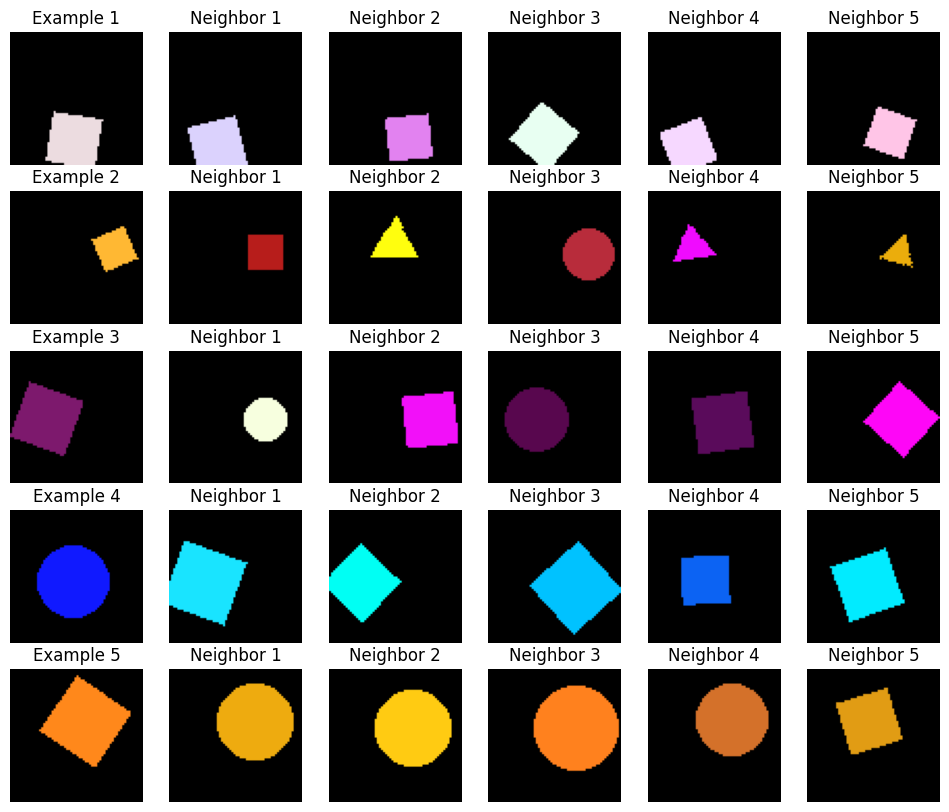

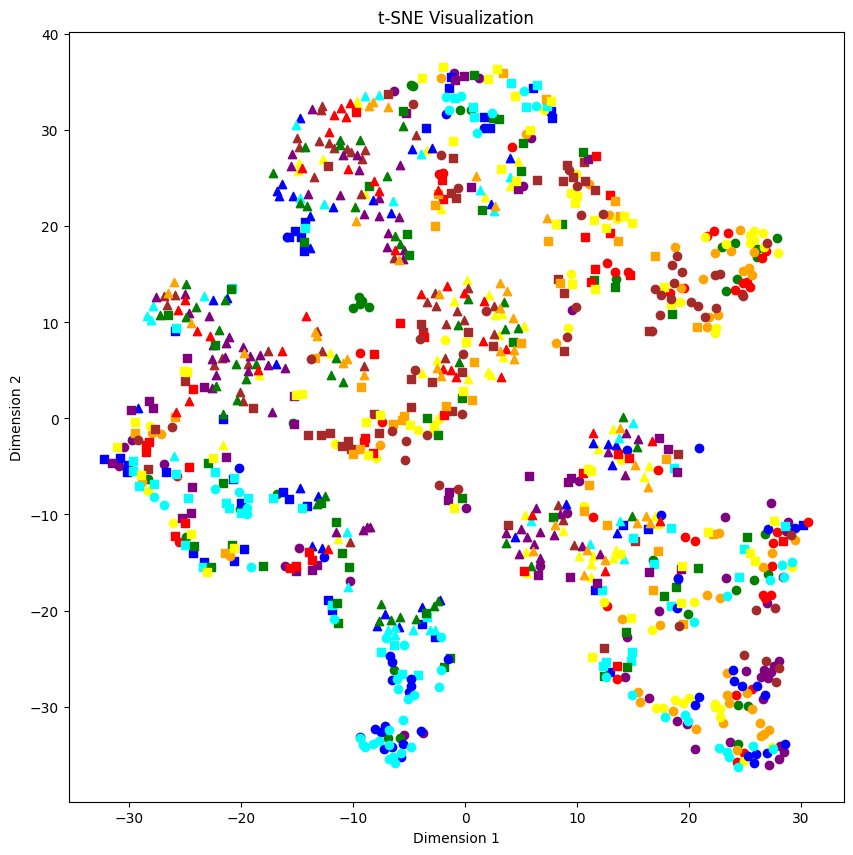

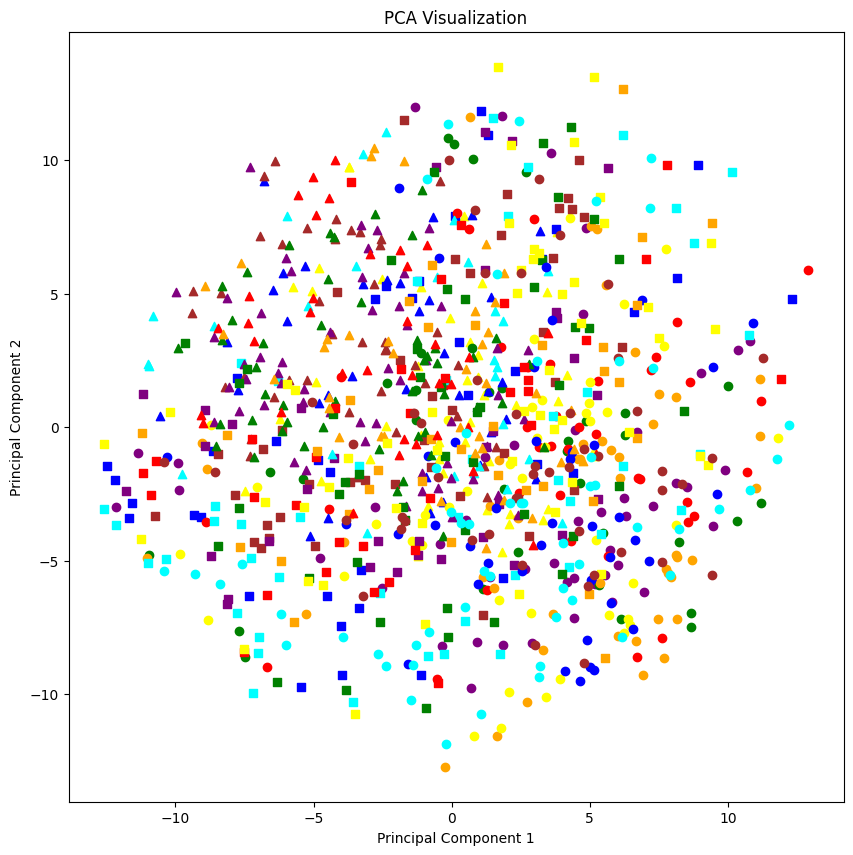

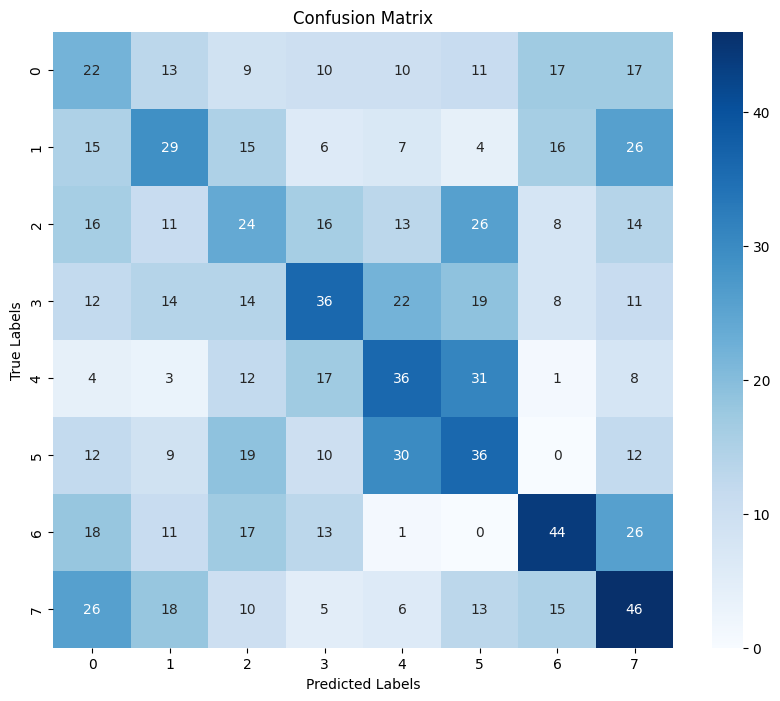

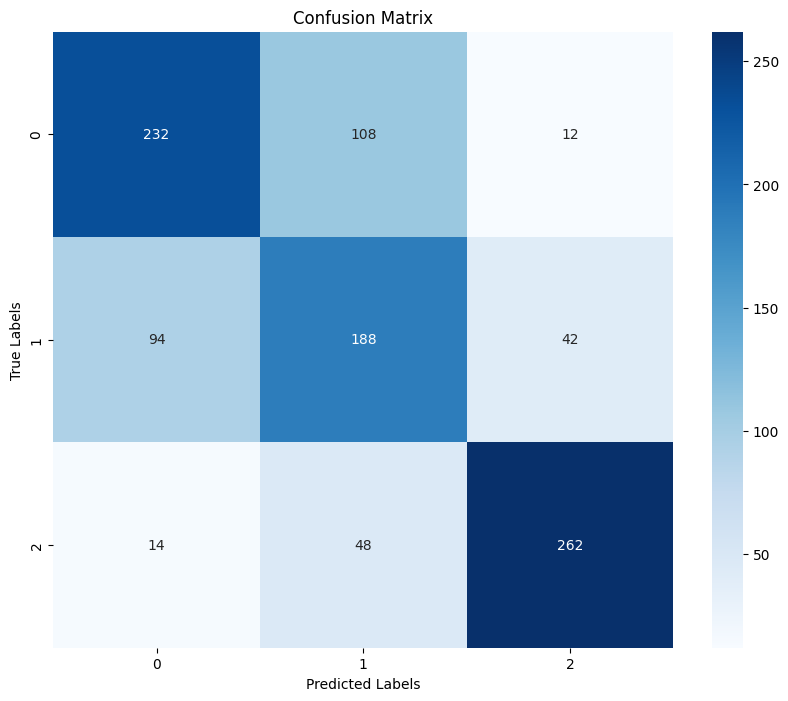

Silhouette Score: -0.13509874045848846
Cluster Purity: 0.197
Normalized Mutual Information (NMI): 0.27667391395443874


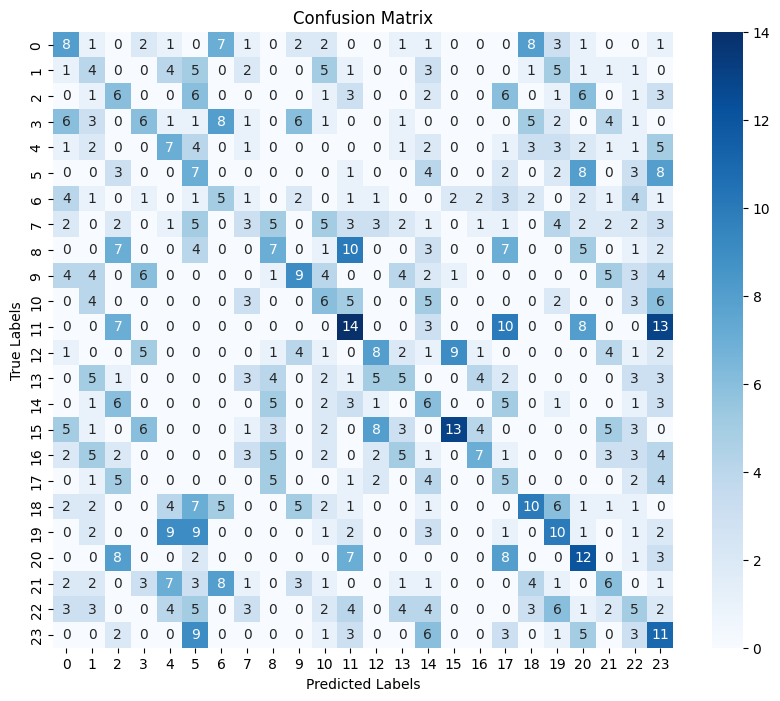

Silhouette Score: -0.053709495812654495
Cluster Purity: 0.221
Normalized Mutual Information (NMI): 0.07400607864957486


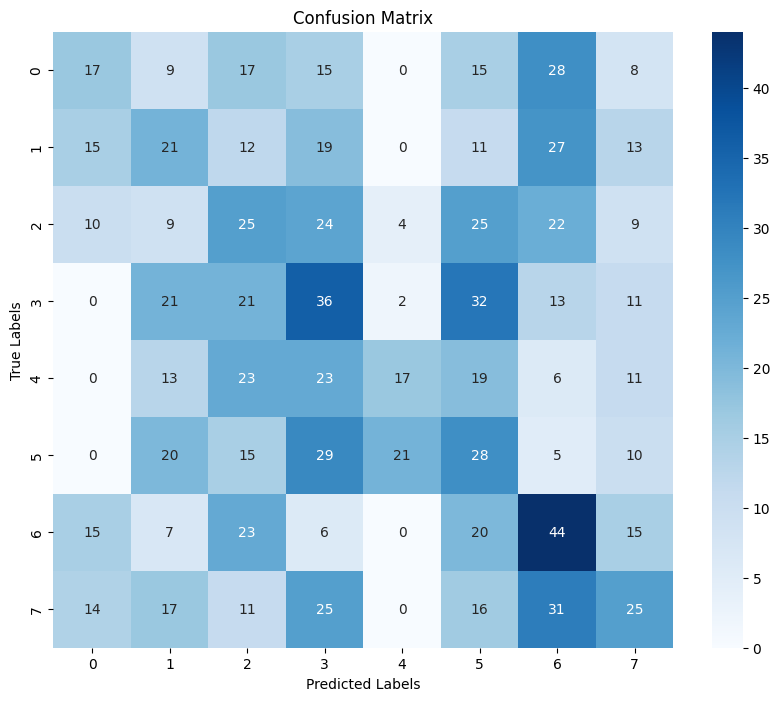

Silhouette Score: 0.04620102792978287
Cluster Purity: 0.532
Normalized Mutual Information (NMI): 0.10639617428749698


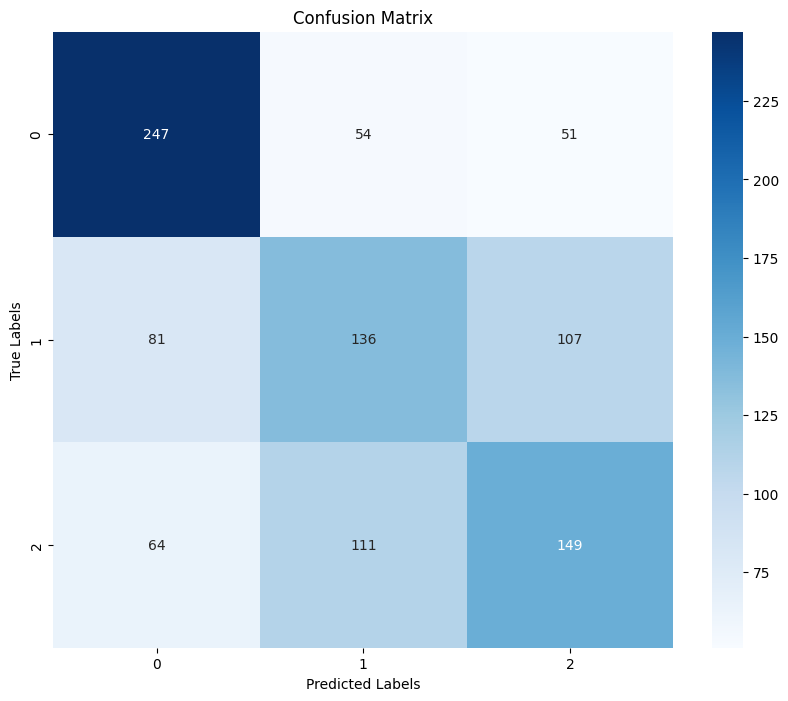

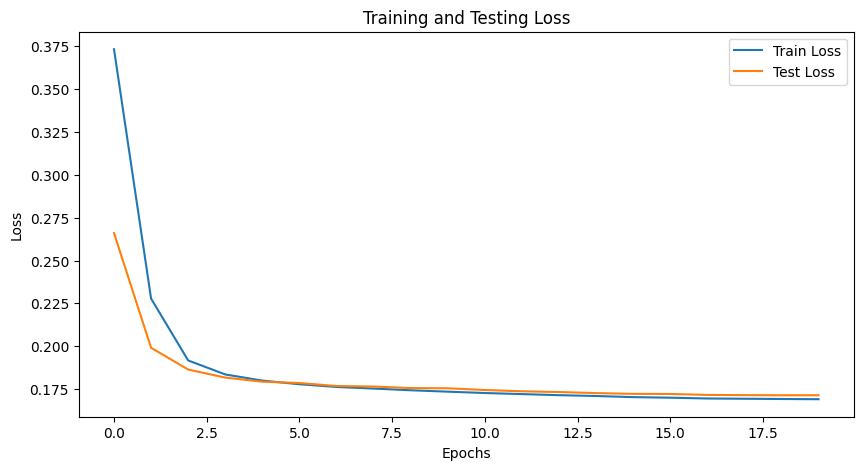

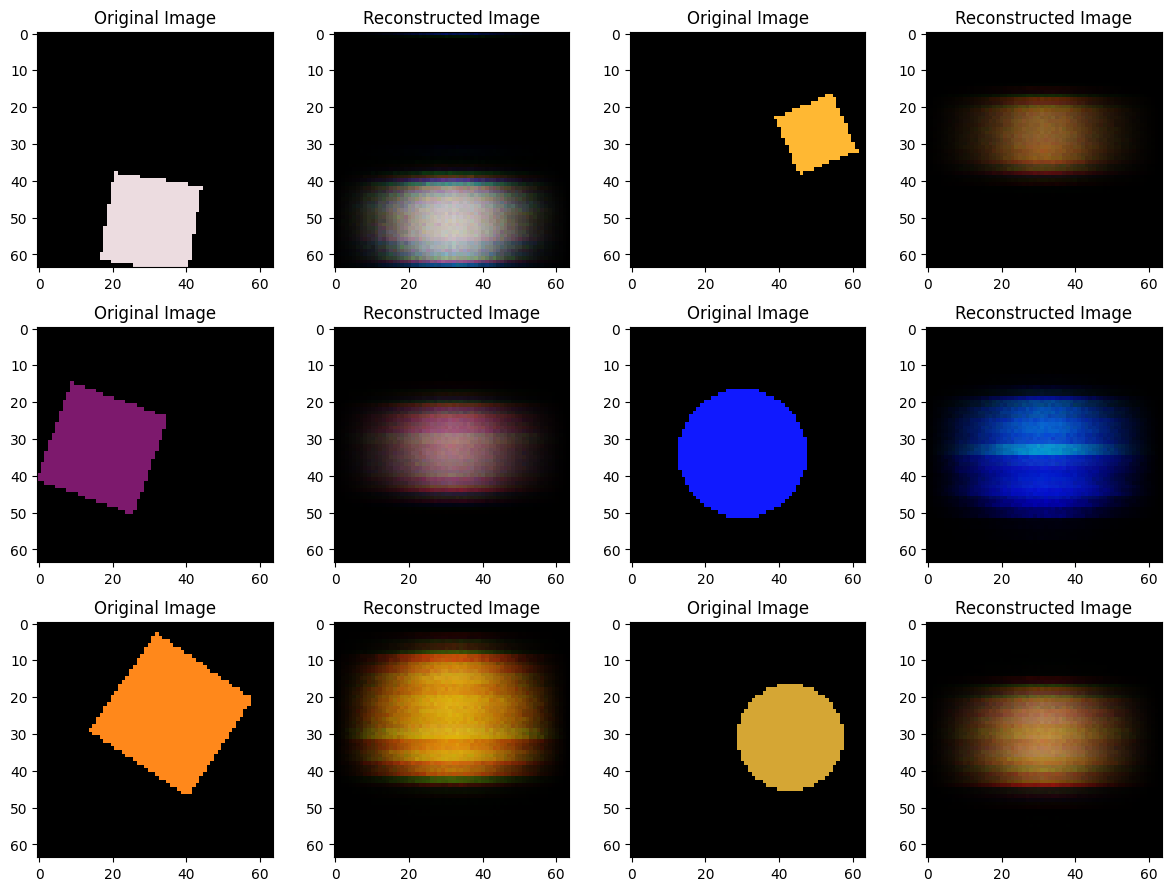

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=4, bias=True)
   (decoder_input): Linear(in_features=4, out_features=8192, 

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 1248584


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.406
Shape Accuracy: 0.718
Combined Accuracy: 0.288


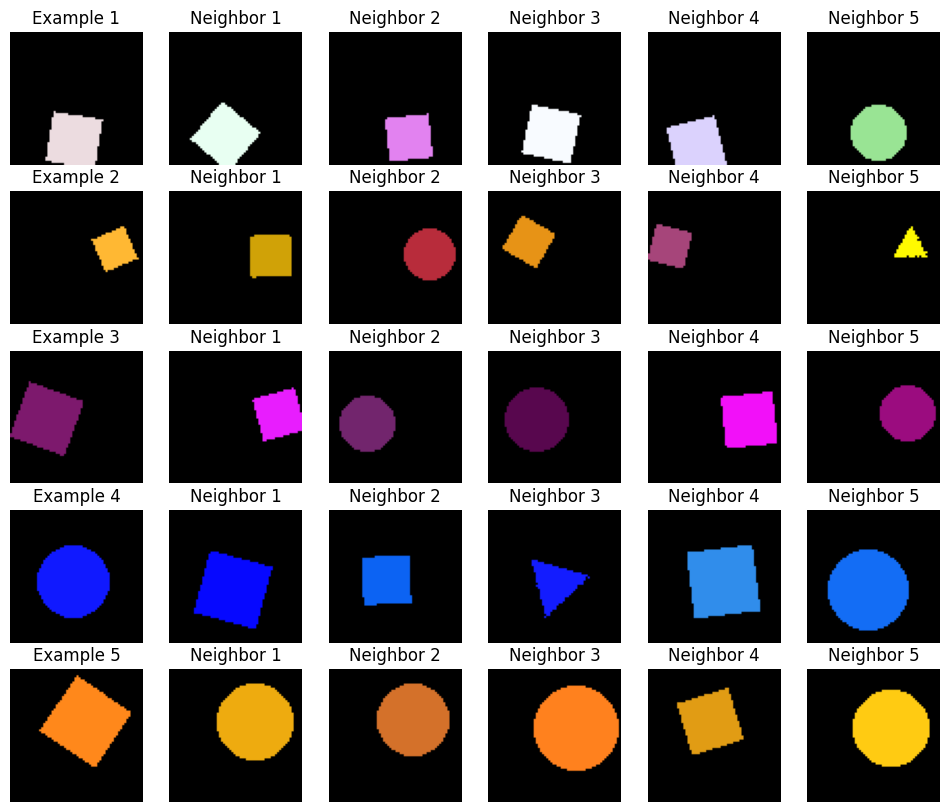

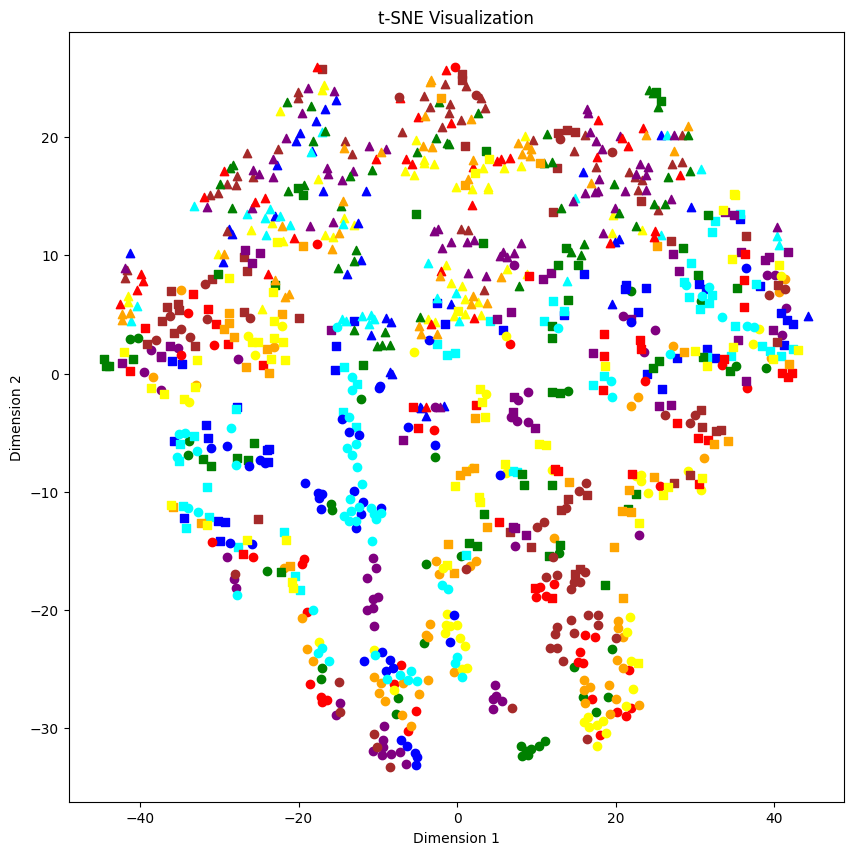

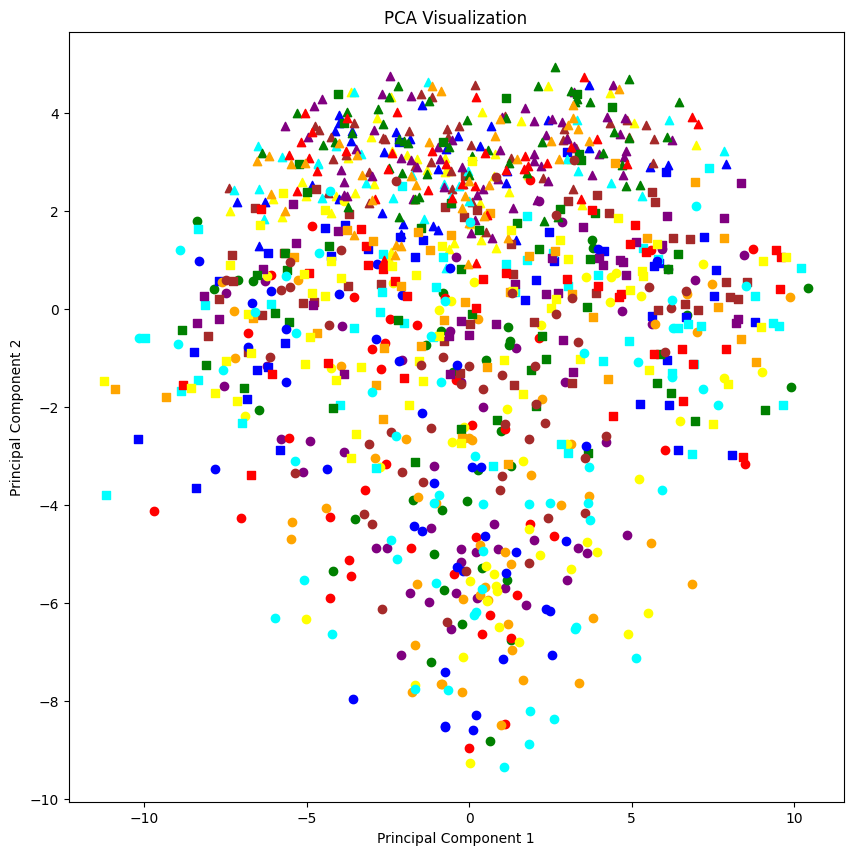

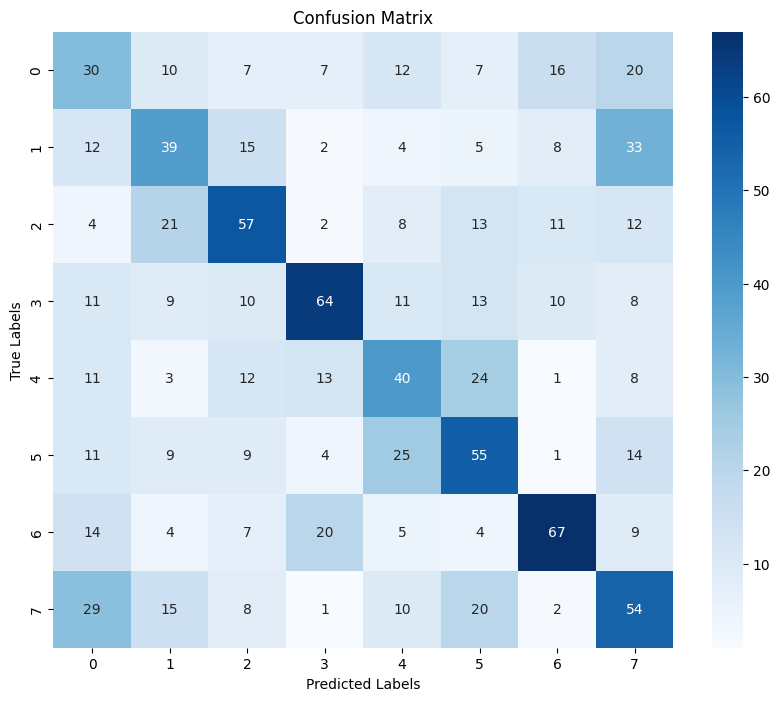

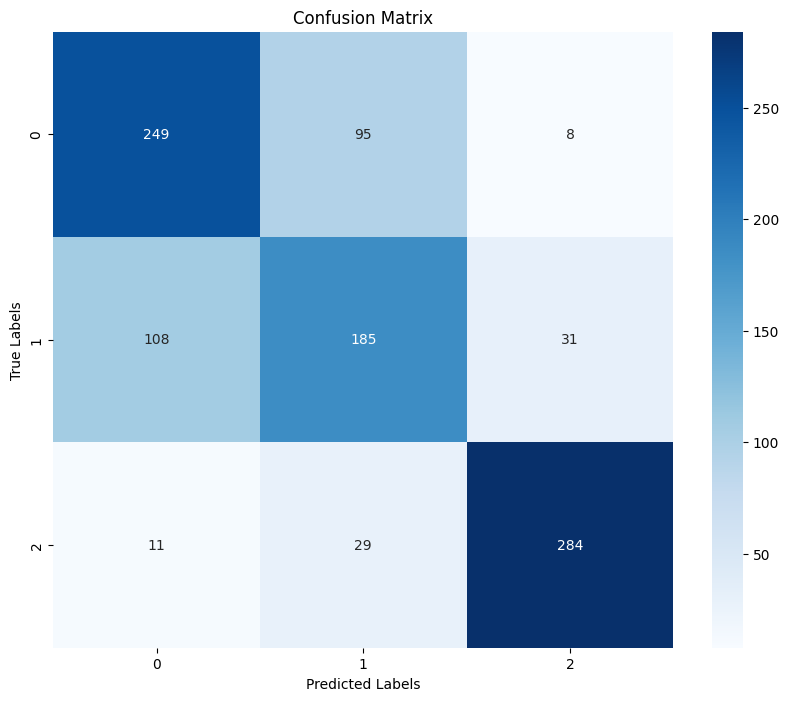

Silhouette Score: -0.09113650768995285
Cluster Purity: 0.211
Normalized Mutual Information (NMI): 0.28498464244021543


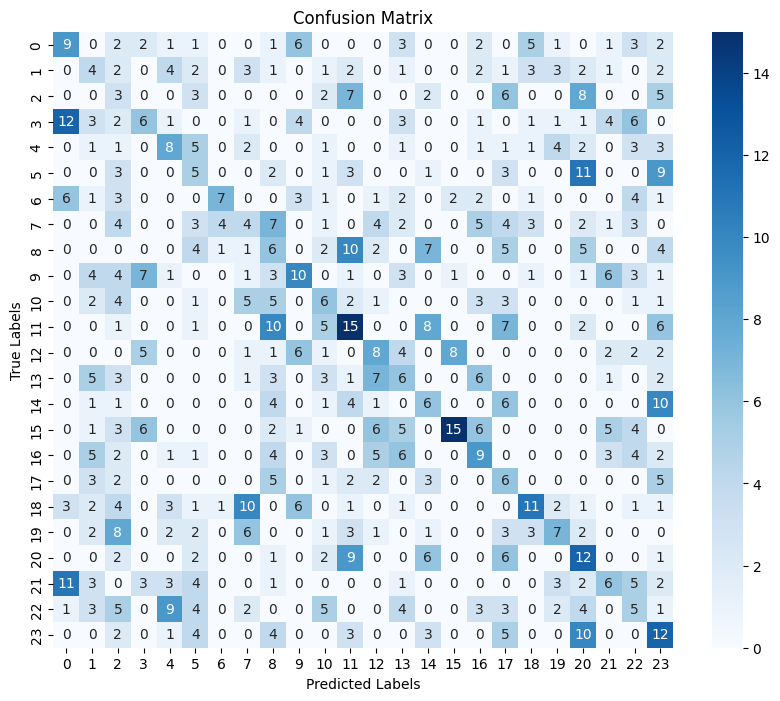

Silhouette Score: -0.031900402158498764
Cluster Purity: 0.198
Normalized Mutual Information (NMI): 0.043148804902622614


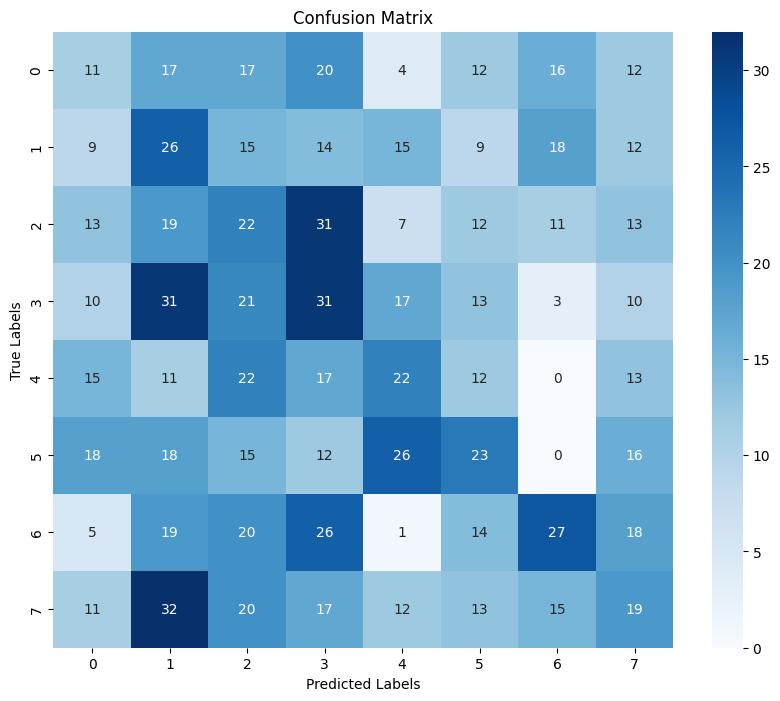

Silhouette Score: 0.060980331152677536
Cluster Purity: 0.554
Normalized Mutual Information (NMI): 0.12512544919126953


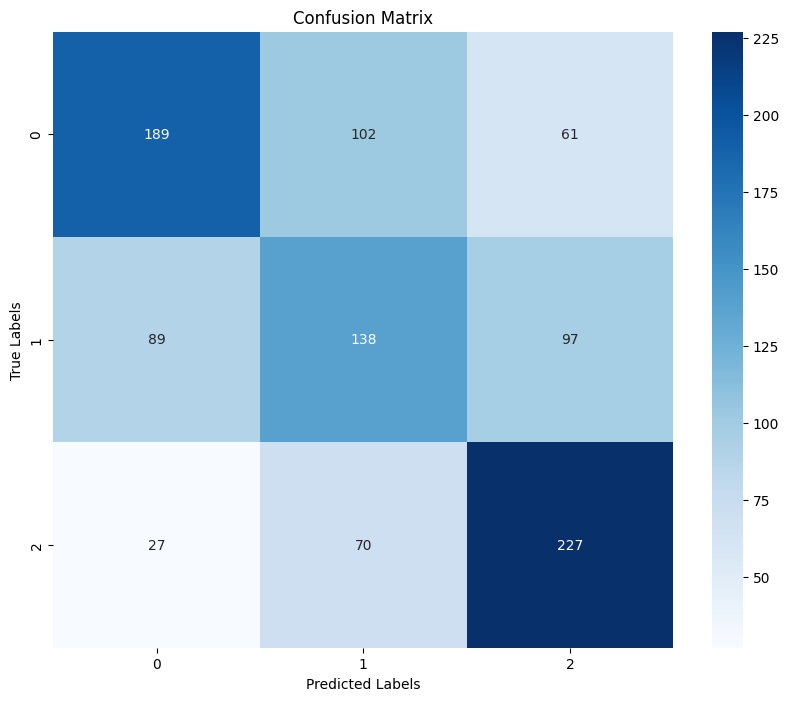

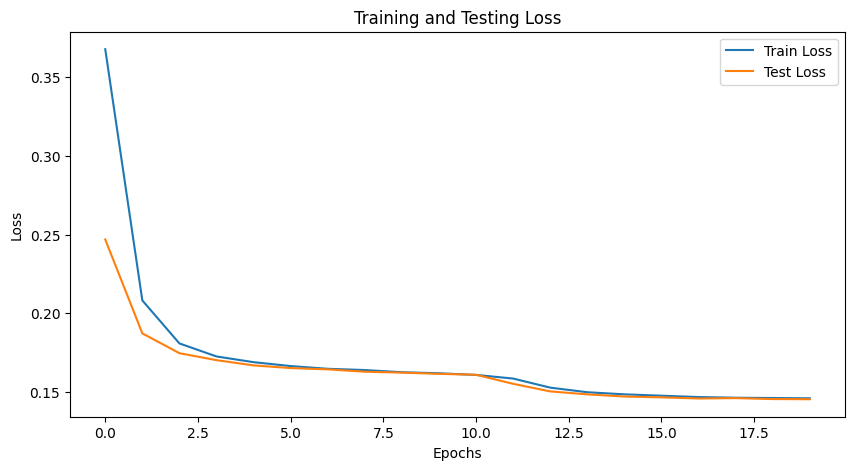

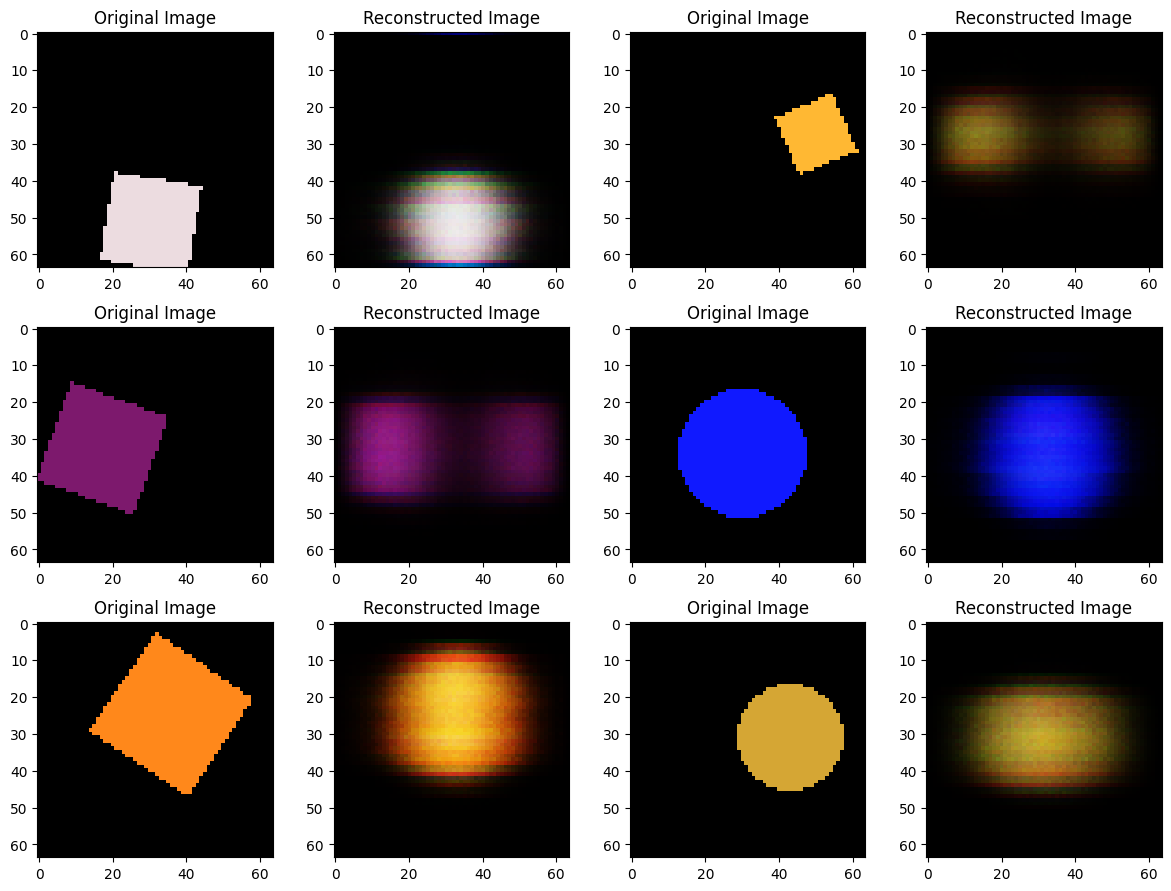

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=8, bias=True)
   (decoder_input): Linear(in_features=8, out_features=8192, 

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1379664


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.373
Shape Accuracy: 0.716
Combined Accuracy: 0.261


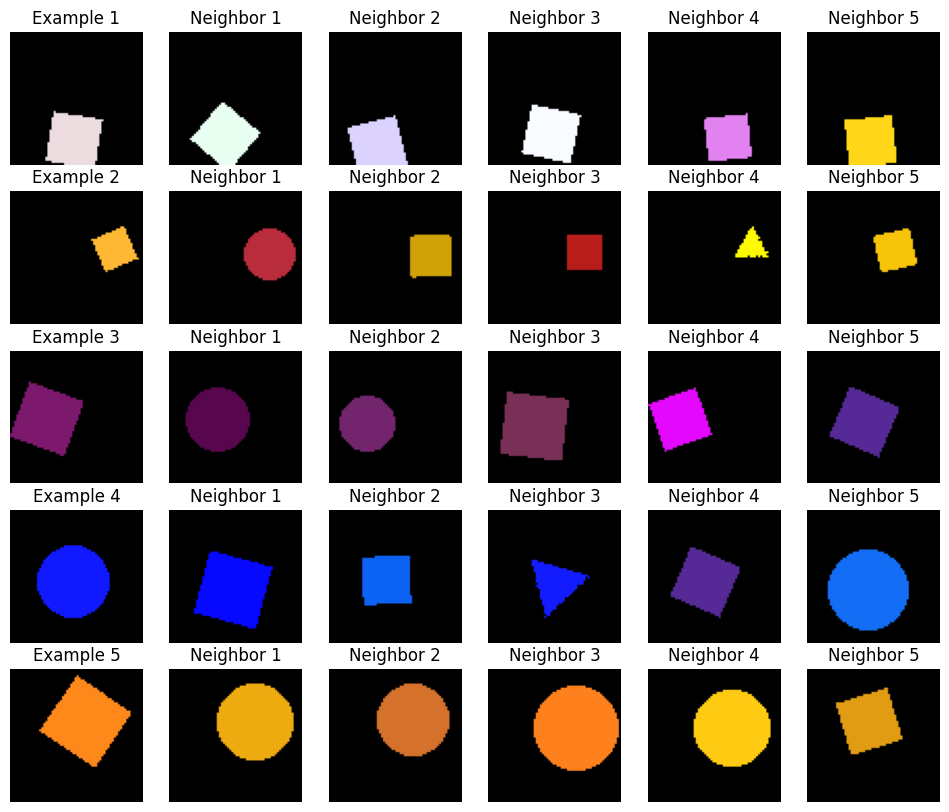

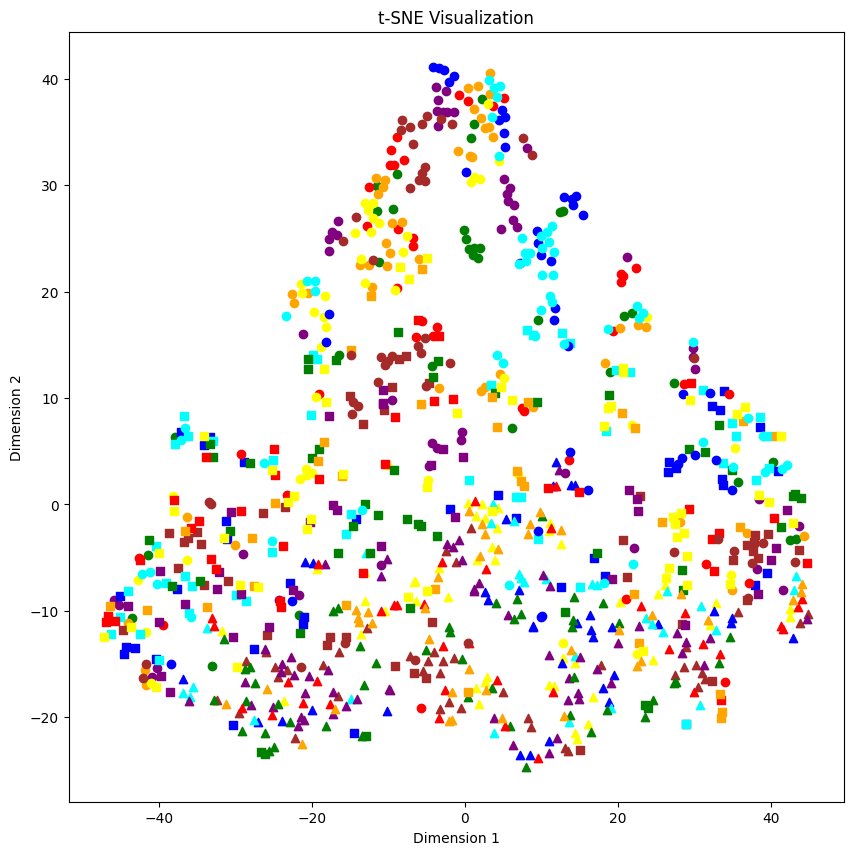

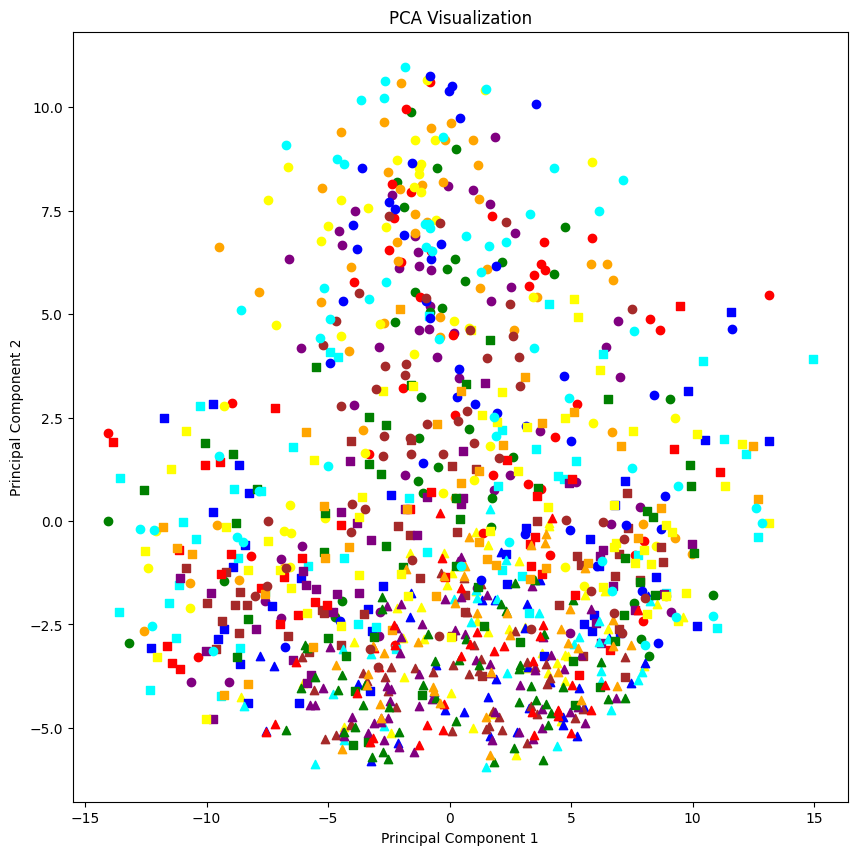

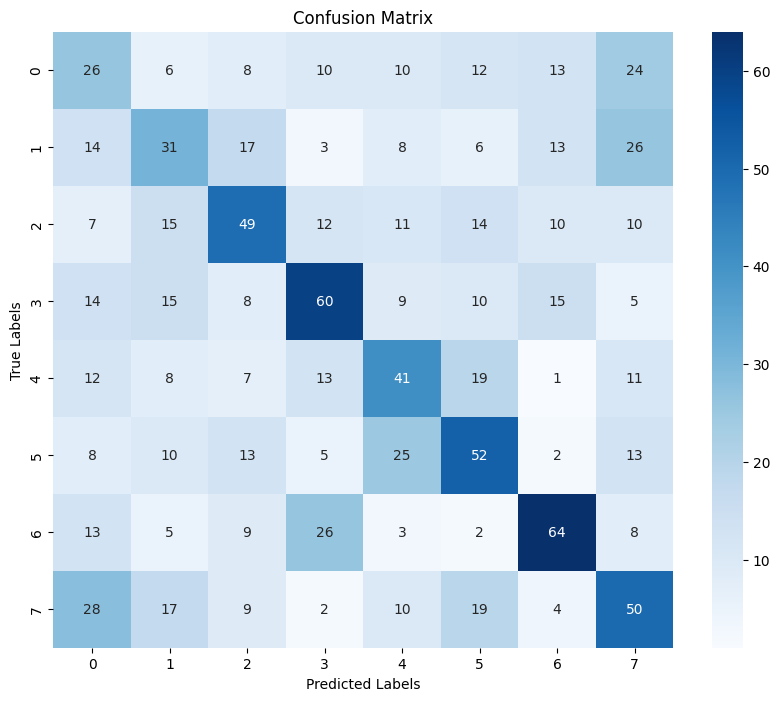

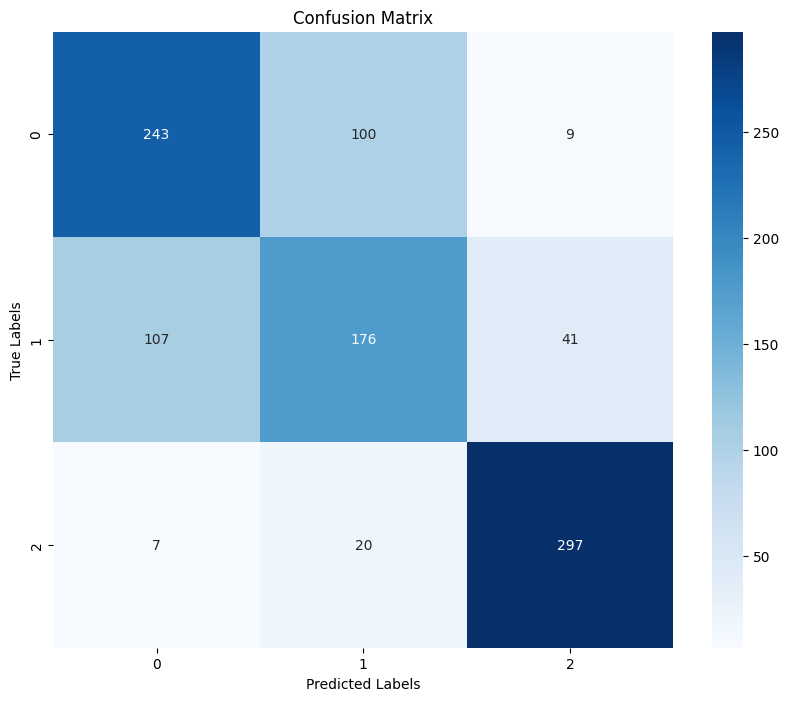

Silhouette Score: -0.09654825180768967
Cluster Purity: 0.208
Normalized Mutual Information (NMI): 0.2832643363931795


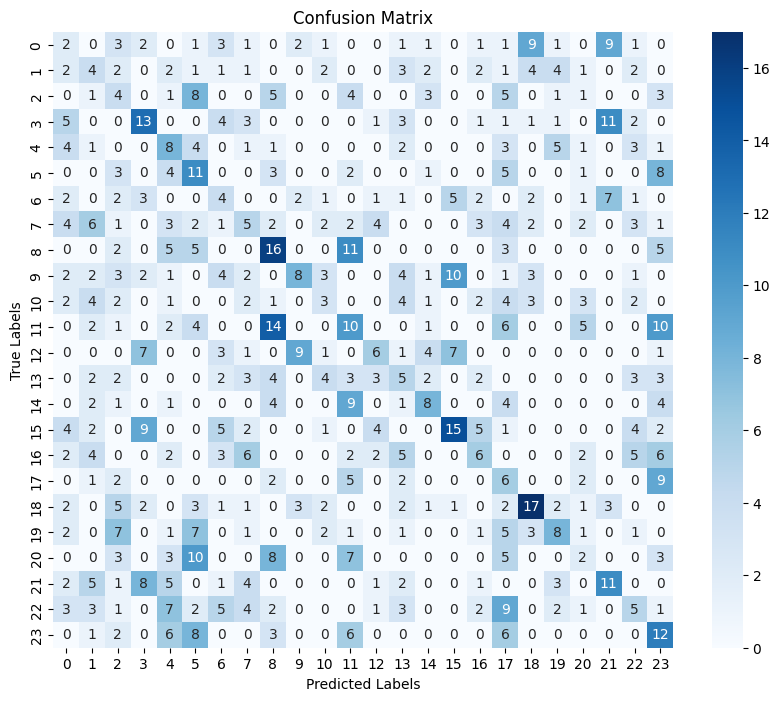

Silhouette Score: -0.04304179921746254
Cluster Purity: 0.205
Normalized Mutual Information (NMI): 0.038030130277158986


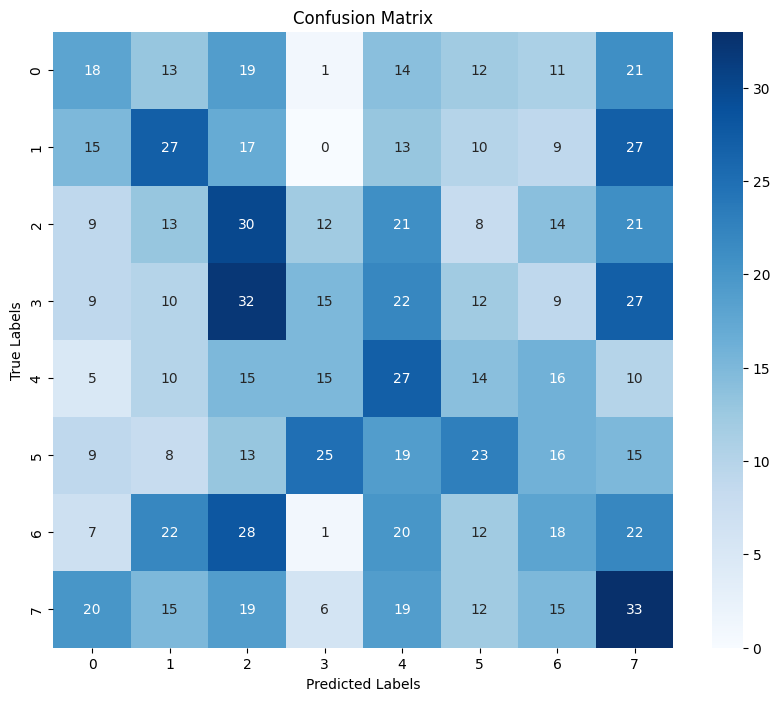

Silhouette Score: 0.0540316179394722
Cluster Purity: 0.571
Normalized Mutual Information (NMI): 0.20924022390824884


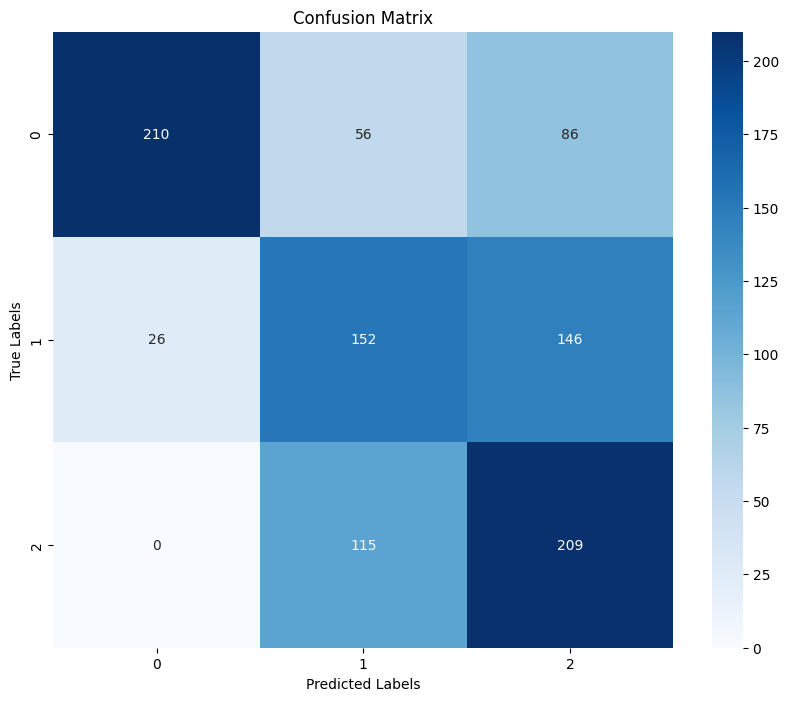

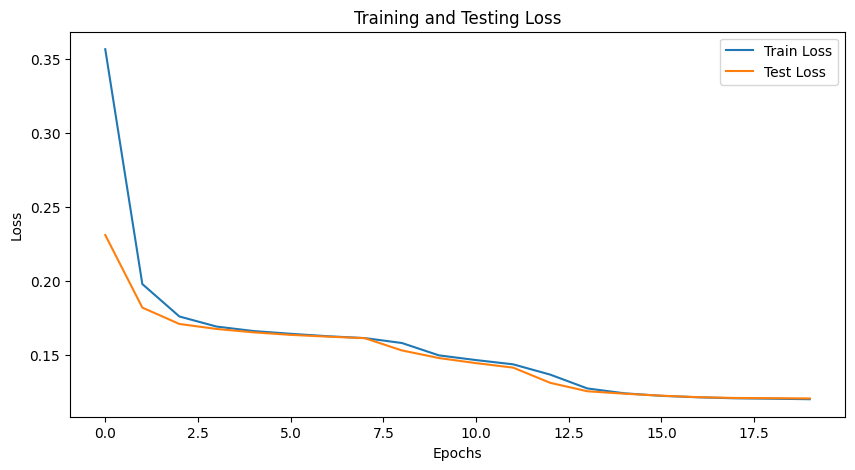

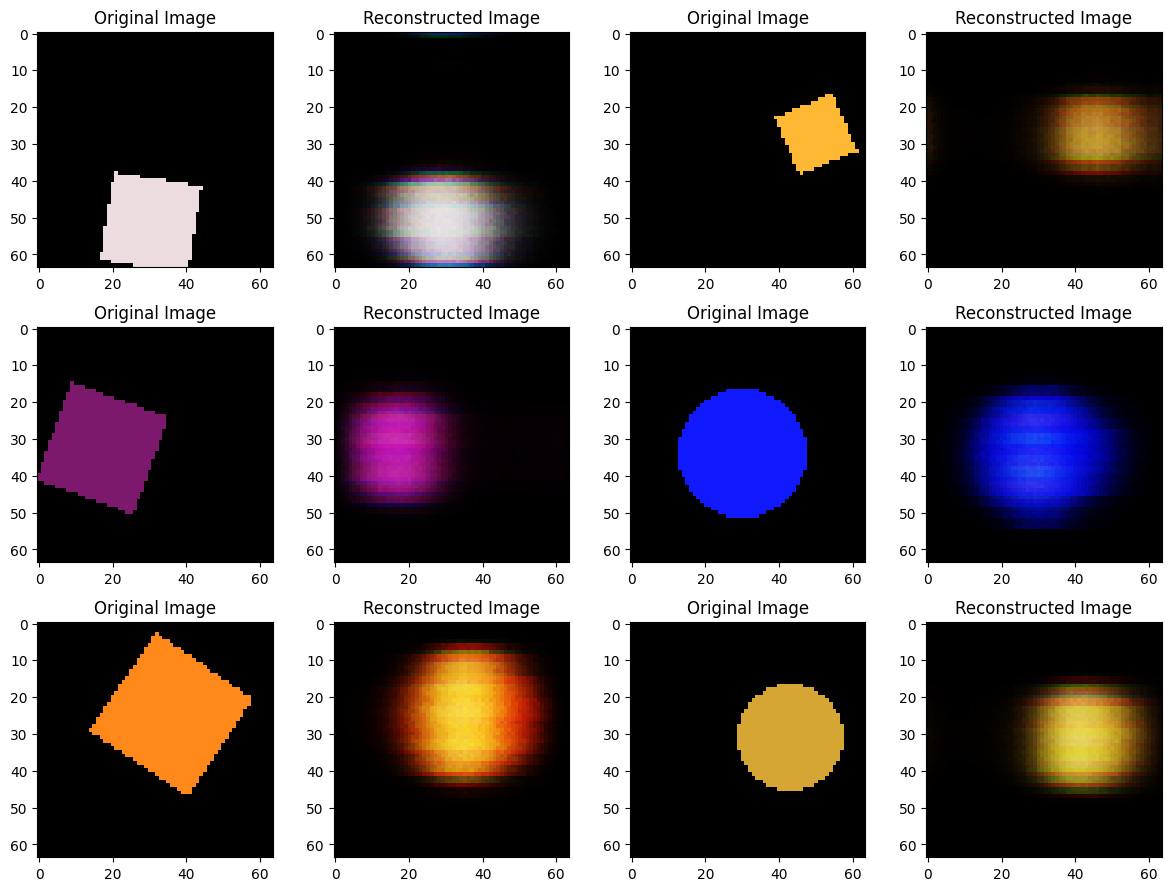

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=16, bias=True)
   (decoder_input): Linear(in_features=16, out_features=8192

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1641824


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.38
Shape Accuracy: 0.725
Combined Accuracy: 0.27


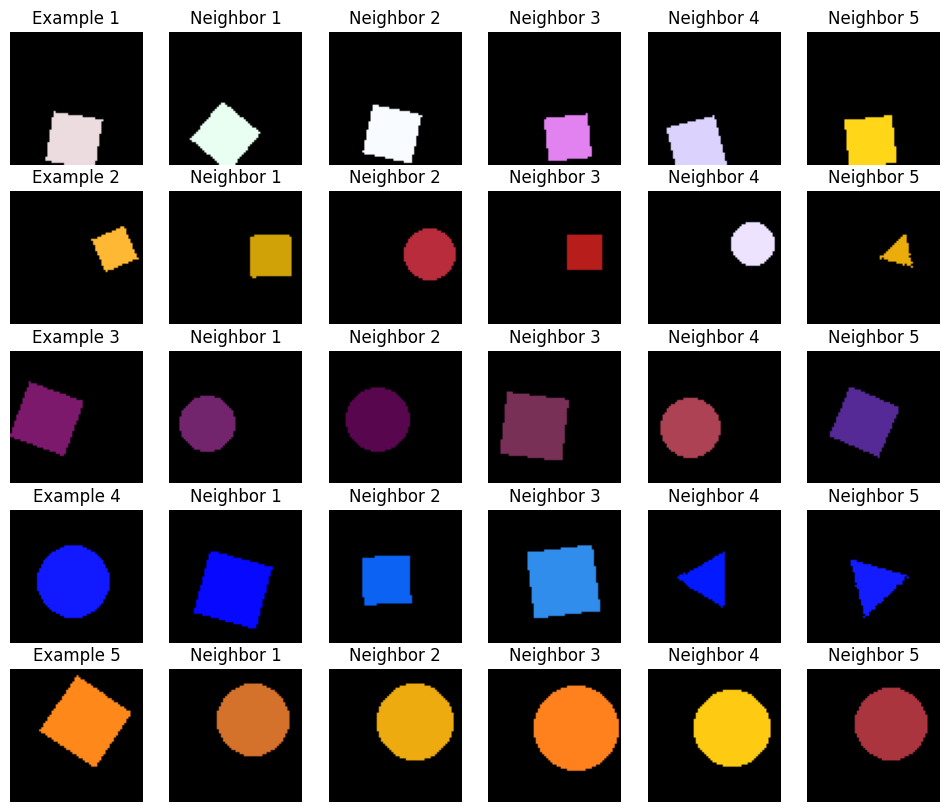

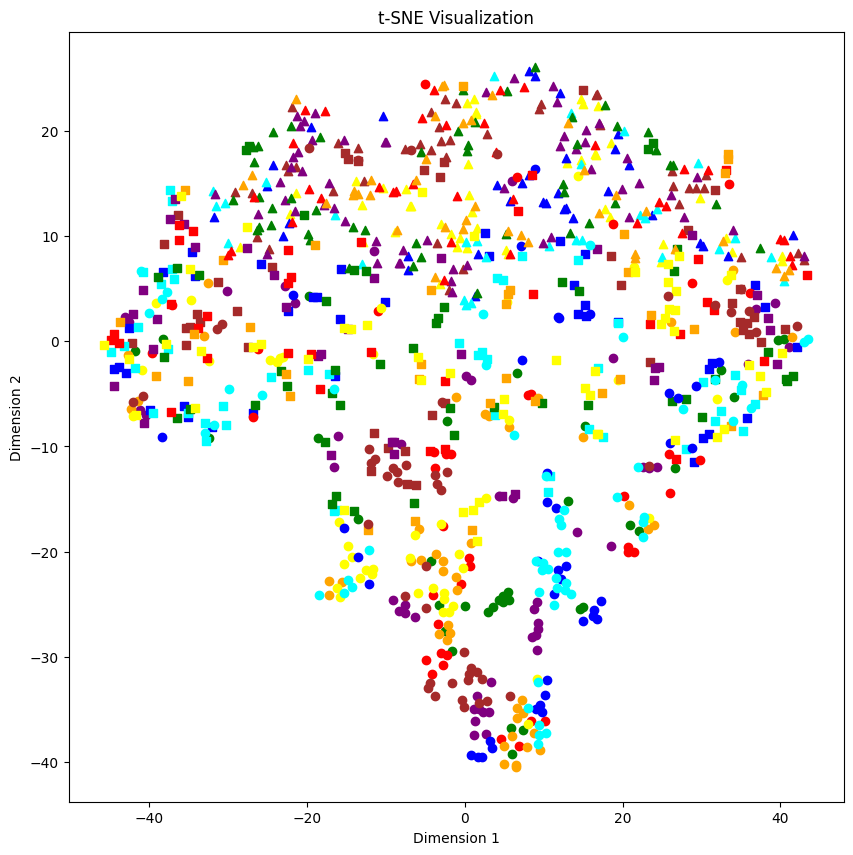

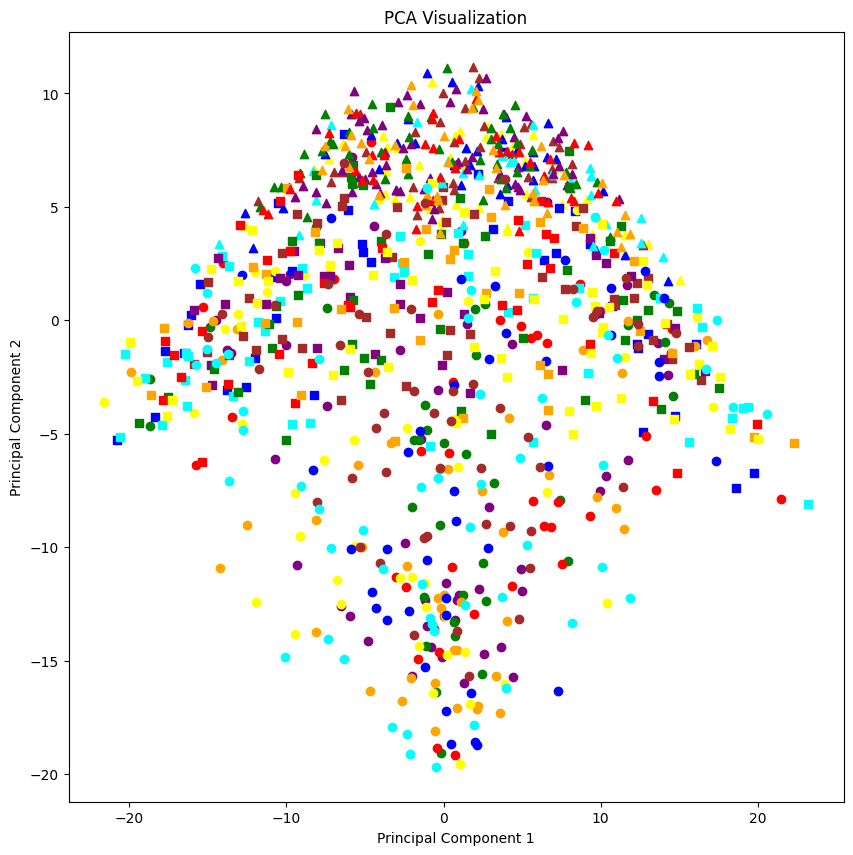

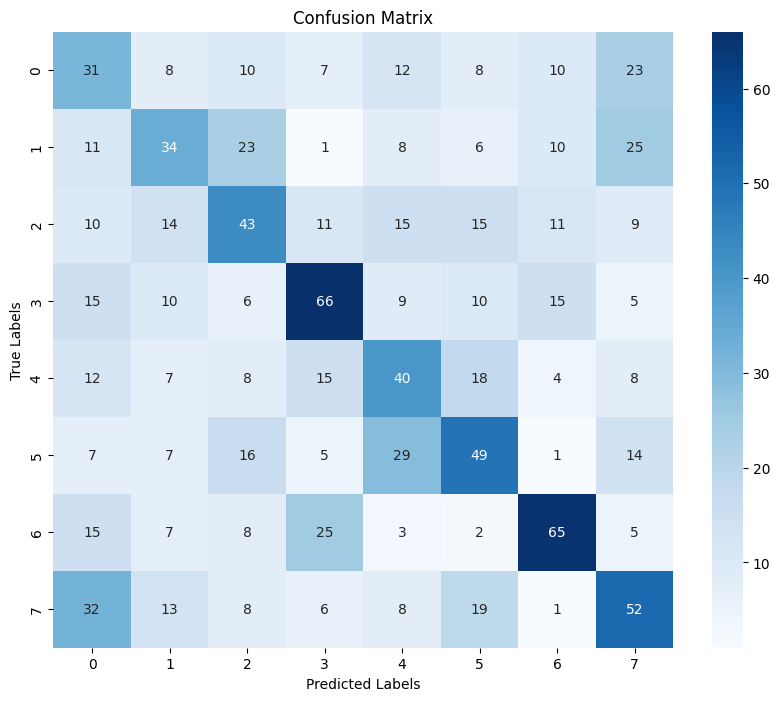

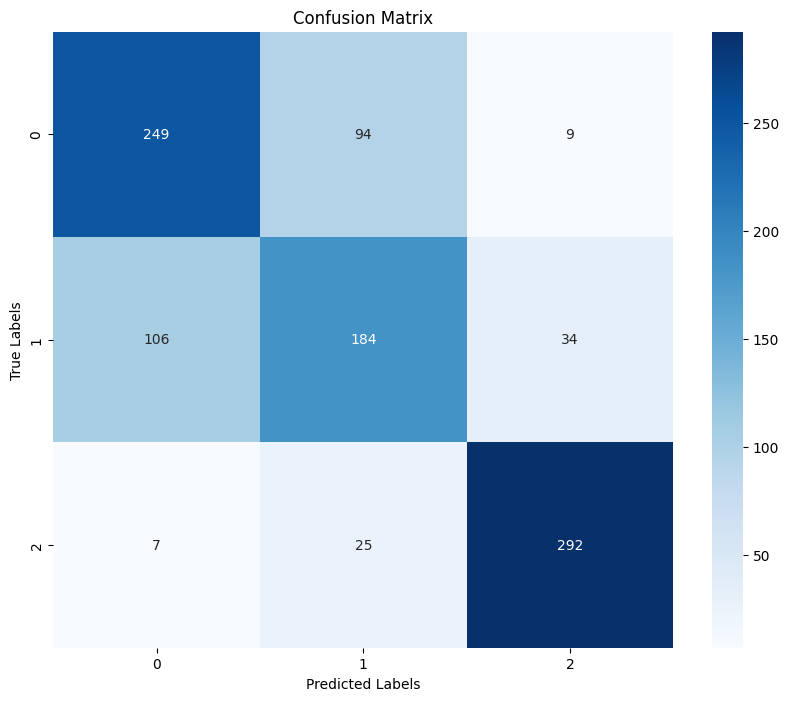

Silhouette Score: -0.08443879336118698
Cluster Purity: 0.213
Normalized Mutual Information (NMI): 0.27483808438738855


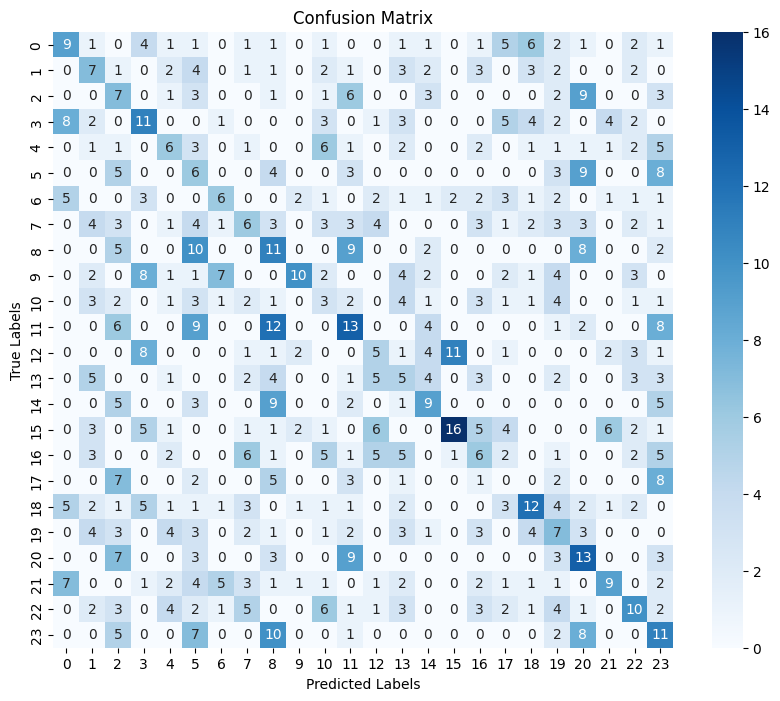

Silhouette Score: -0.03353860601782799
Cluster Purity: 0.204
Normalized Mutual Information (NMI): 0.04813750122219889


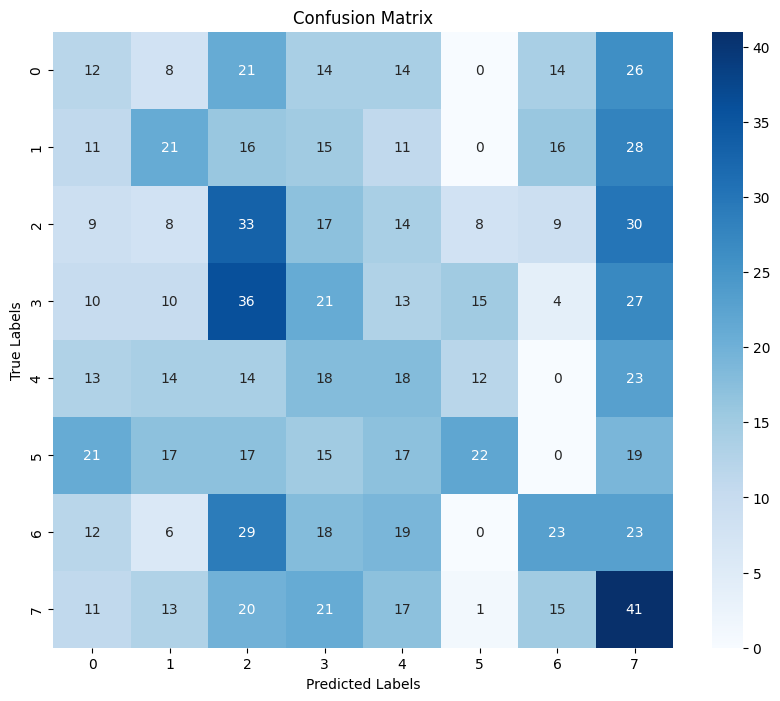

Silhouette Score: 0.06160924583673477
Cluster Purity: 0.611
Normalized Mutual Information (NMI): 0.20611587199367123


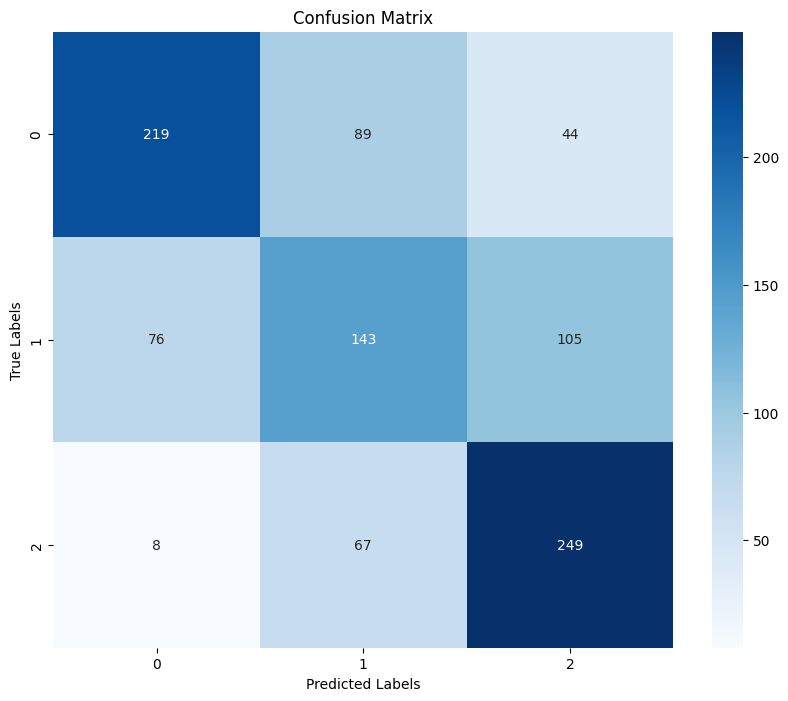

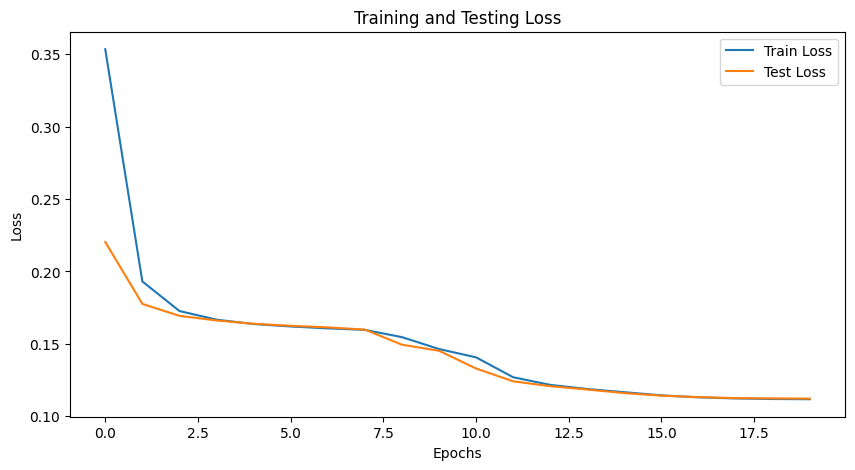

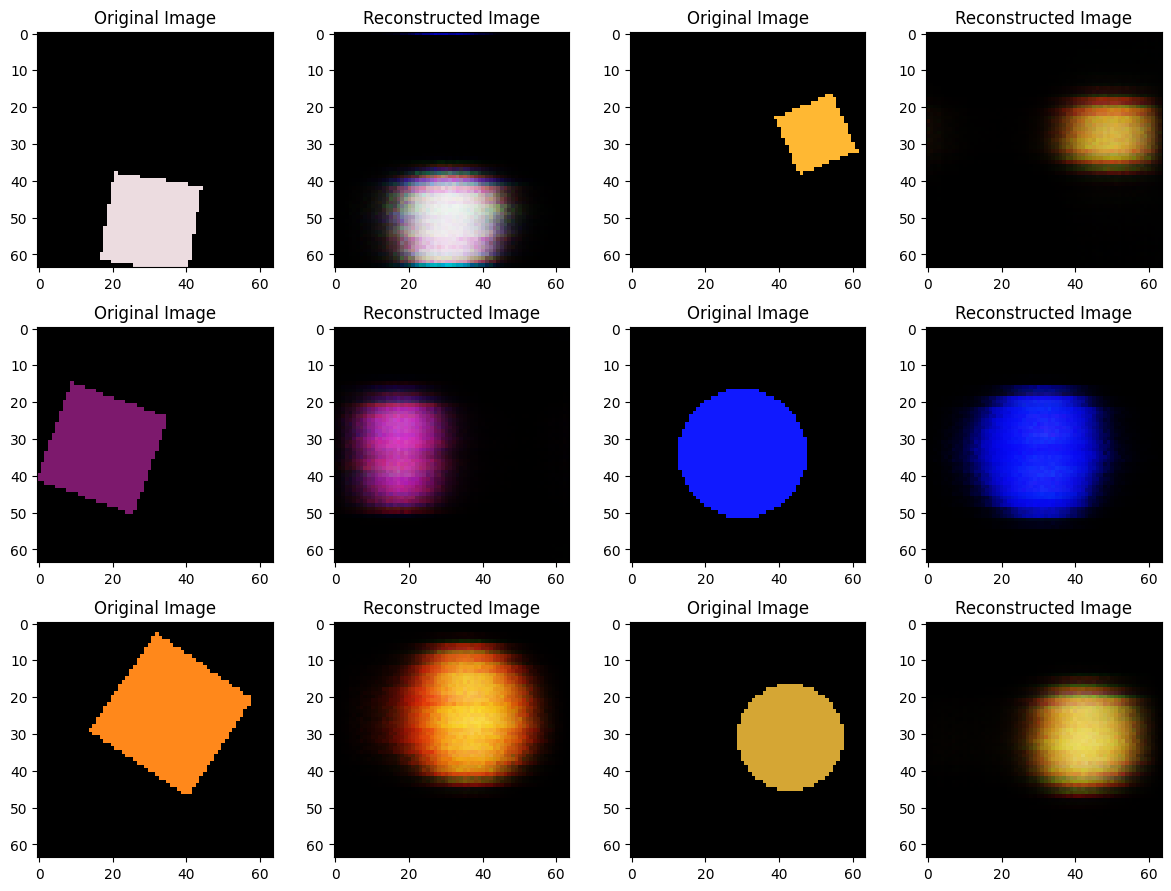

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=32, bias=True)
   (decoder_input): Linear(in_features=32, out_features=8192

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 2166144


/Users/criyle/project/cse5524/cse5524final/util.py:380: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(train_embeddings)
/Users/criyle/project/cse5524/cse5524final/util.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings)


Color Accuracy: 0.368
Shape Accuracy: 0.726
Combined Accuracy: 0.254


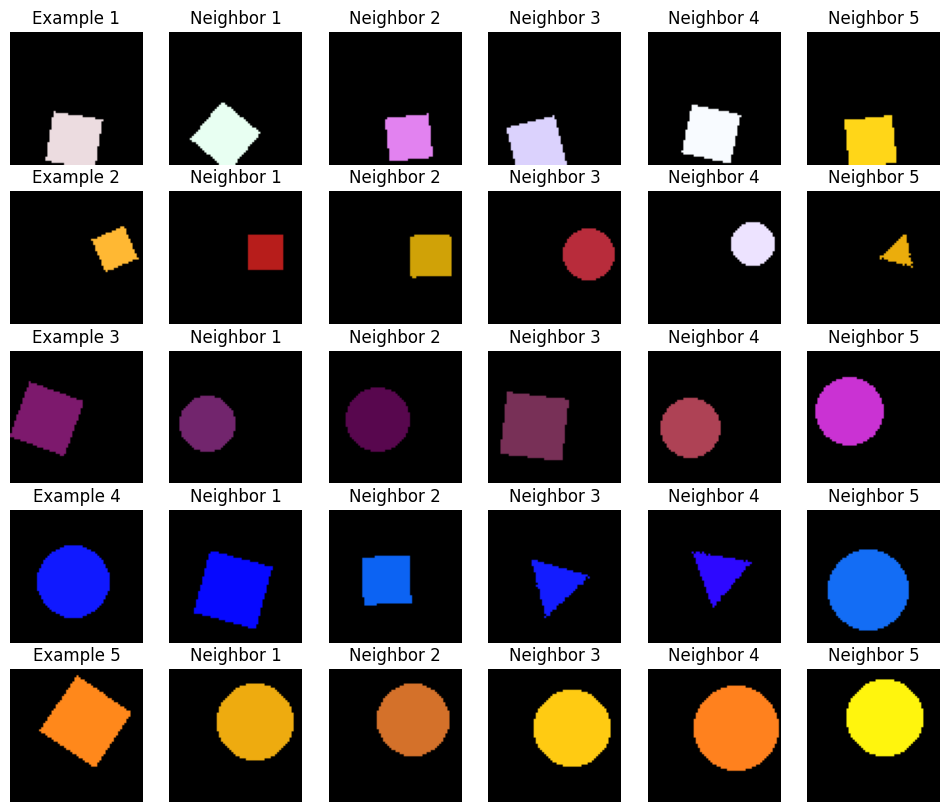

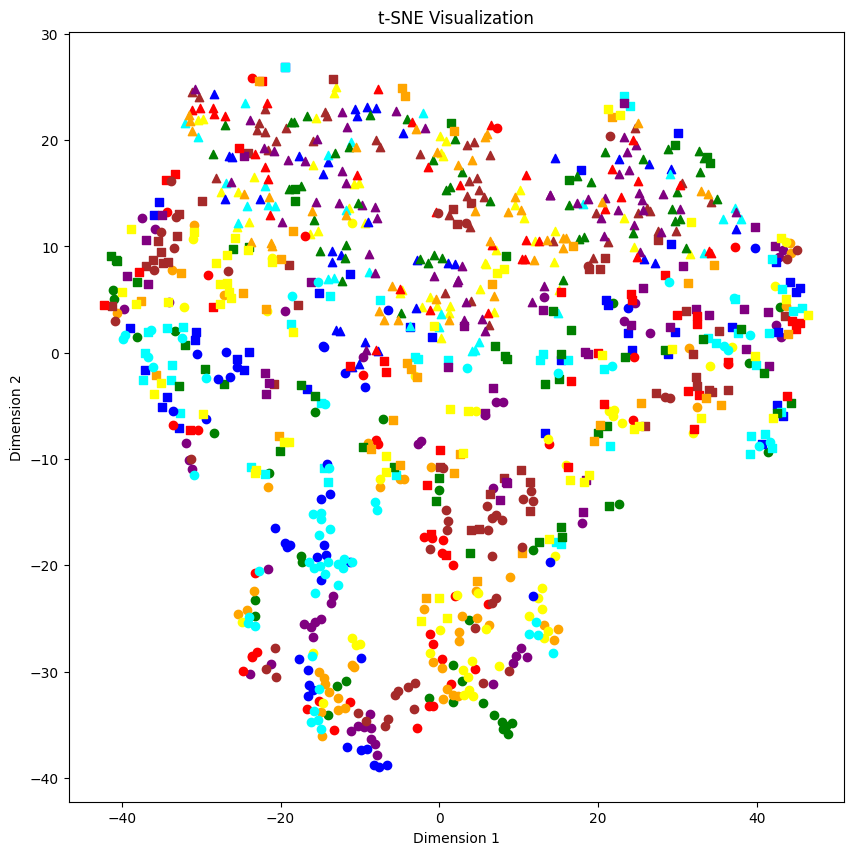

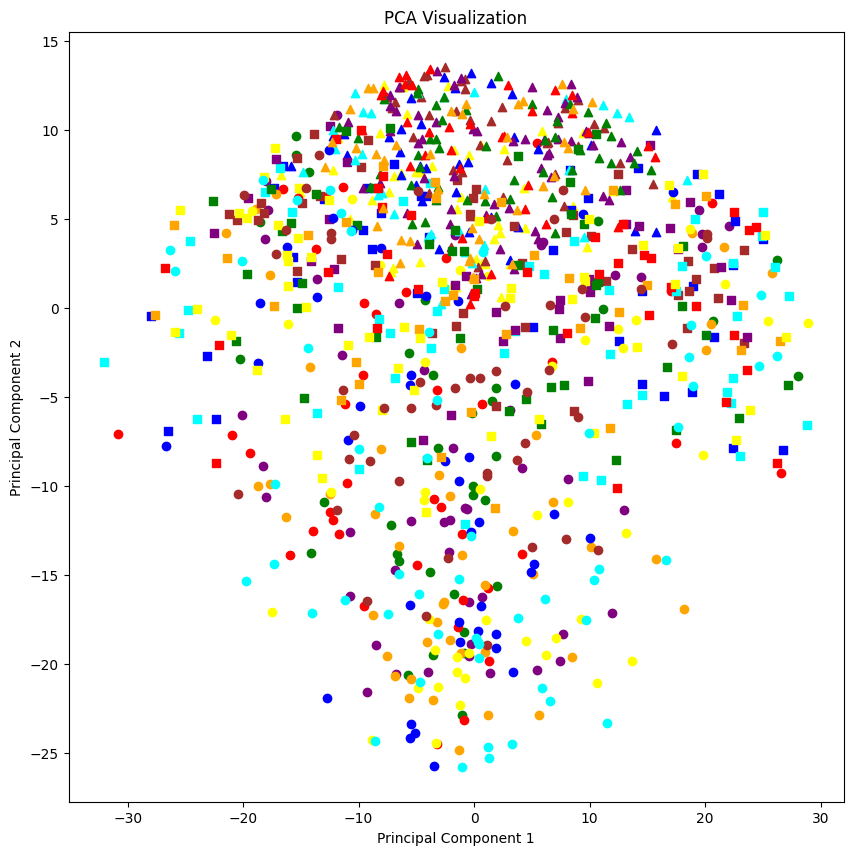

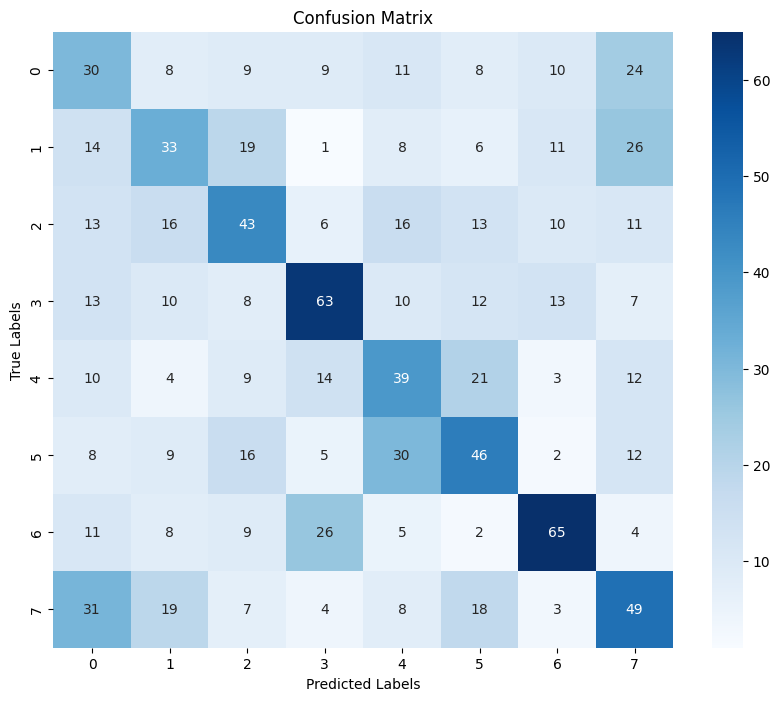

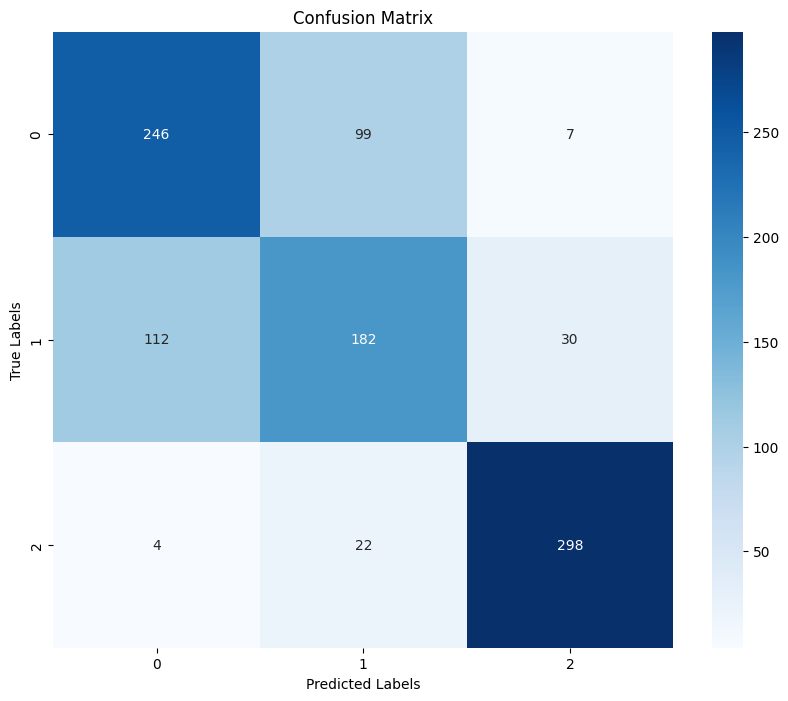

Silhouette Score: -0.08819941431283951
Cluster Purity: 0.2
Normalized Mutual Information (NMI): 0.27209165274571345


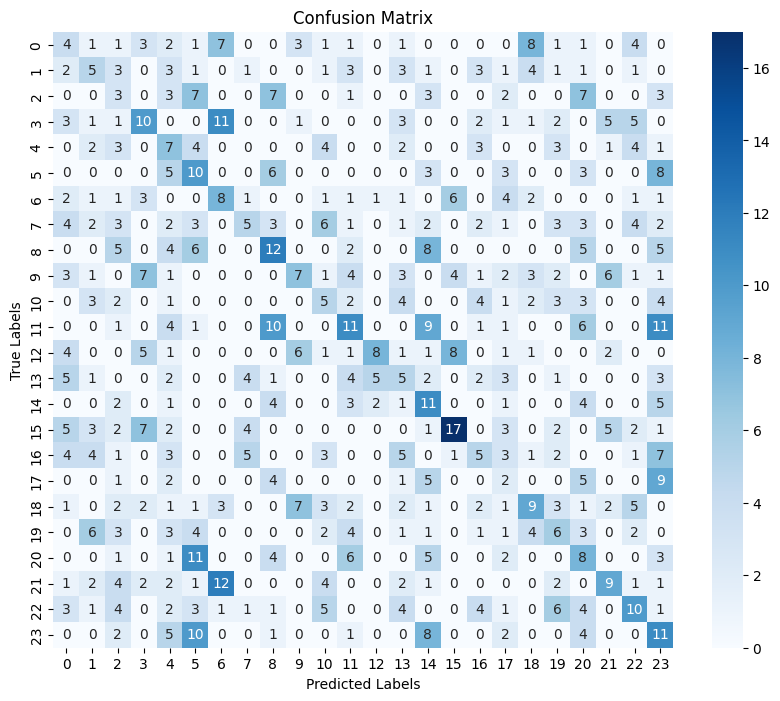

Silhouette Score: -0.02832849696278572
Cluster Purity: 0.21
Normalized Mutual Information (NMI): 0.05457955942415517


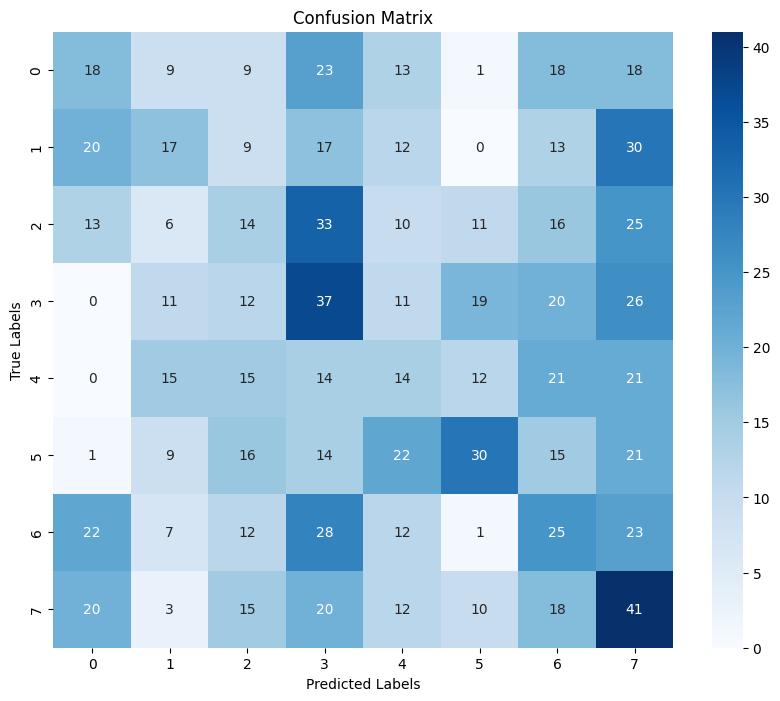

Silhouette Score: 0.045279309153556824
Cluster Purity: 0.571
Normalized Mutual Information (NMI): 0.21667279408736395


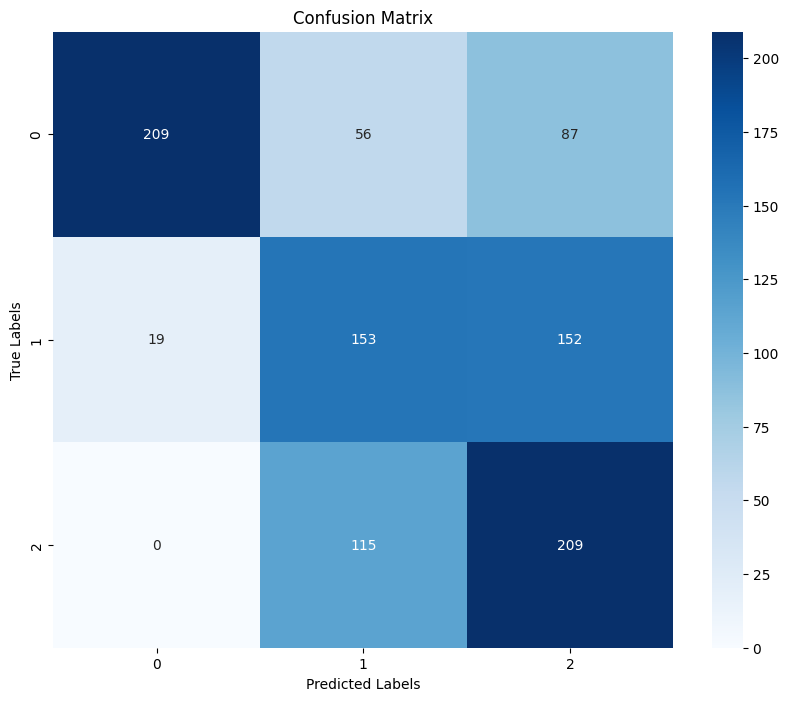

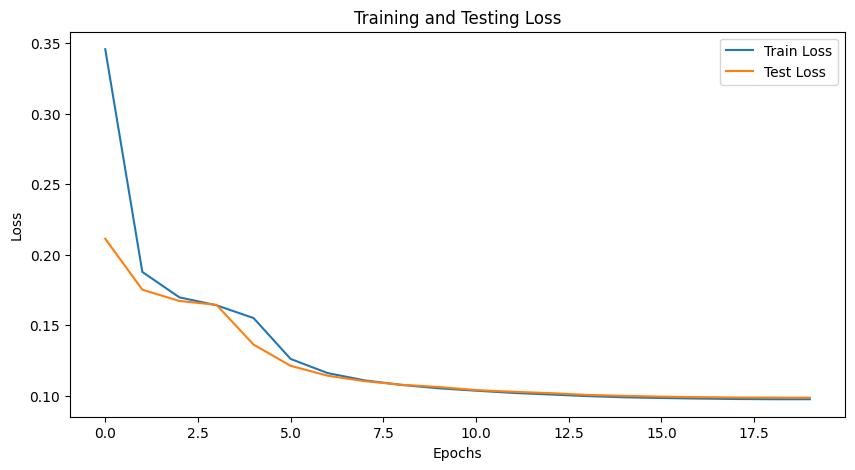

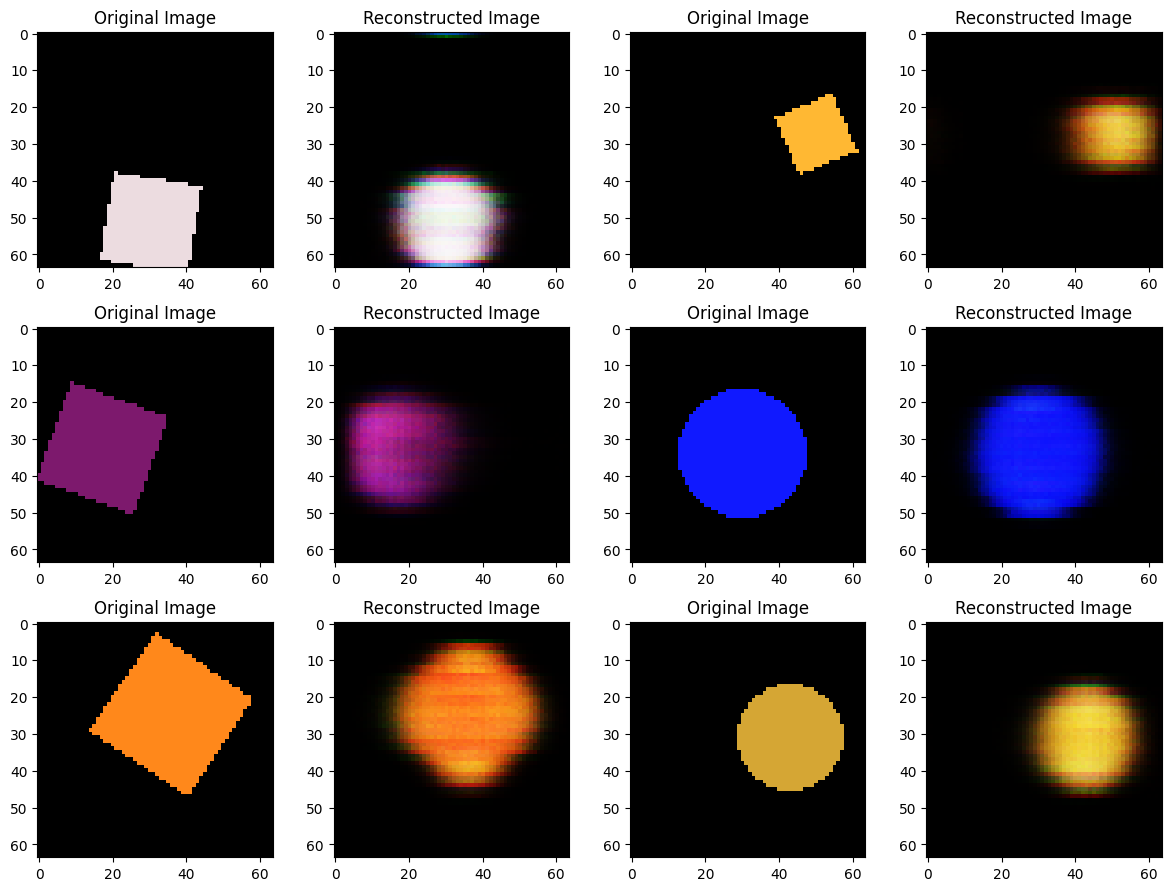

(TransformerAutoencoder(
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-3): 4 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=256, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=256, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
   (positional_encoding): PositionalEncoding2D()
   (bottleneck): Linear(in_features=8192, out_features=64, bias=True)
   (decoder_input): Linear(in_features=64, out_features=8192

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)

In [9]:
print(accuracy)

{4: (273, 682, 206), 8: (406, 718, 288), 16: (373, 716, 261), 32: (380, 725, 270), 64: (368, 726, 254)}
